# Credit Risk Resampling Techniques

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

import seaborn as sns

# Read the CSV into DataFrame

In [17]:


# Load the data
lending_data = pd.read_csv('./Resources/lending_data.csv')
lending_data.head()

,loan_size,interest_rate,homeowner,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,own,52800,0.431818,5,1,22800,low_risk
1,8400.0,6.692,own,43600,0.311927,3,0,13600,low_risk
2,9000.0,6.963,rent,46100,0.349241,3,0,16100,low_risk
3,10700.0,7.664,own,52700,0.430740,5,1,22700,low_risk
4,10800.0,7.698,mortgage,53000,0.433962,5,1,23000,low_risk


# Split the Data into Training and Testing

In [18]:
# Create our features
X = lending_data.drop(columns='loan_status')
X = pd.get_dummies(X, columns=['homeowner'])

# Create our target
y = lending_data['loan_status']
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
y = y_encoded

In [19]:
X.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,homeowner_mortgage,homeowner_own,homeowner_rent
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.497472,0.398911,0.103616
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.499997,0.489678,0.304764
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000,0.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000,0.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,1.000000,1.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000,1.000000,1.000000


In [20]:
# Check the balance of our target values
Counter(y)

Counter({1: 75036, 0: 2500})

In [21]:
# Create X_train, X_test, y_train, y_test
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
    X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [22]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
scaler = StandardScaler()
X_scaler = scaler.fit(X_train_unscaled)

In [23]:
# Scale the training and testing data
X_train = X_scaler.transform(X_train_unscaled)
X_test = X_scaler.transform(X_test_unscaled)

In [24]:
# Create a helper function to visualize the confusion matrices
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=['High Risk', 'Low Risk'])
    disp.plot()
    plt.show()

# Simple Logistic Regression

In [25]:
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)

In [26]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_lr)

0.9889115309798473

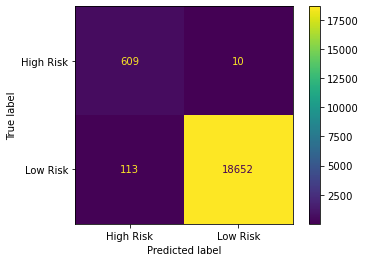

In [27]:
# Display the confusion matrix
plot_confusion_matrix(y_test, y_pred_lr)

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_lr))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.98      0.99      0.91      0.99      0.98       619
          1       1.00      0.99      0.98      1.00      0.99      0.98     18765

avg / total       0.99      0.99      0.98      0.99      0.99      0.98     19384



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [29]:
# Resample the training data with the RandomOversampler
ros = RandomOverSampler(random_state=1)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_train_ros)

Counter({1: 56271, 0: 56271})

In [30]:
# Train the Logistic Regression model using the resampled data
model.fit(X_train_ros, y_train_ros)
y_pred_ros = model.predict(X_test)

In [31]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_ros)

0.9934649587814939

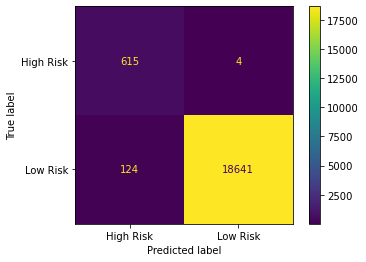

In [32]:
# Display the confusion matrix
plot_confusion_matrix(y_test, y_pred_ros)

In [33]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_ros))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.99      0.99      0.91      0.99      0.99       619
          1       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



### SMOTE Oversampling

In [34]:
# Resample the training data with SMOTE
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_train_smote)

Counter({1: 56271, 0: 56271})

In [35]:
# Train the Logistic Regression model using the resampled data
model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test)

In [36]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_smote)

0.9934649587814939

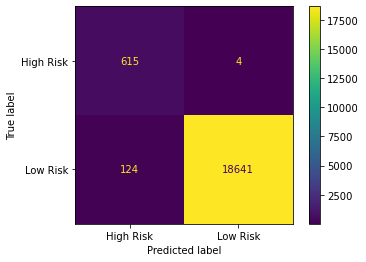

In [37]:
# Display the confusion matrix
plot_confusion_matrix(y_test, y_pred_smote)

In [38]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_smote))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.99      0.99      0.91      0.99      0.99       619
          1       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



# Undersampling

In this section, you will test an undersampling algorithm to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [39]:
# Resample the data using the ClusterCentroids resampler
cc = ClusterCentroids(random_state=1)
X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_train_cc)

Counter({0: 1881, 1: 1881})

In [40]:
# Train the Logistic Regression model using the resampled data
model.fit(X_train_cc, y_train_cc)
y_pred_cc = model.predict(X_test)

In [41]:
# Calculate the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_cc)

0.9929503031930944

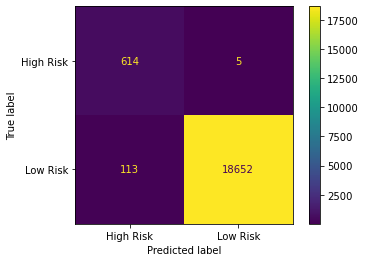

In [42]:
# Display the confusion matrix
plot_confusion_matrix(y_test, y_pred_cc)

In [43]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_cc))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.99      0.99      0.91      0.99      0.99       619
          1       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Display the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [44]:
# Resample the training data with SMOTEENN
smoteenn = SMOTEENN(random_state=1)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# View the count of target classes with Counter
Counter(y_train_smoteenn)

Counter({0: 55653, 1: 55934})

In [45]:
# Train the Logistic Regression model using the resampled data
model.fit(X_train_smoteenn, y_train_smoteenn)
y_pred_smoteenn = model.predict(X_test)

In [46]:
# Calculate the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_smoteenn)

0.9934649587814939

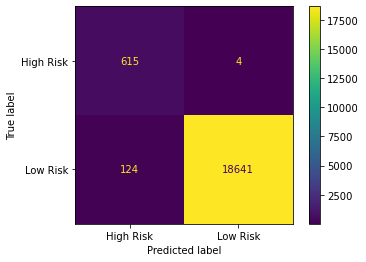

In [47]:
# Display the confusion matrix
plot_confusion_matrix(y_test, y_pred_smoteenn)

In [48]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_smoteenn))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.83      0.99      0.99      0.91      0.99      0.99       619
          1       1.00      0.99      0.99      1.00      0.99      0.99     18765

avg / total       0.99      0.99      0.99      0.99      0.99      0.99     19384



# Final Questions

1. Which model had the best balanced accuracy score?

   Oversampling and combination sampling models had the highest balanced accuracy score at `0.9934649587814939`.

2. Which model had the best recall score?

   Each model had the same average recall score of `0.99`.

3. Which model had the best geometric mean score?

    Each model had the same average geometric mean score of `0.99`.
